In [1]:
import pandas as pd
deliveries_df = pd.read_csv("innings_deliveries.csv")

print(deliveries_df.head())

                          team  over        batter    bowler   non_striker  \
0  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   
1  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   
2  Royal Challengers Bengaluru     0  F du Plessis  I Sharma       V Kohli   
3  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   
4  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   

   runs_batter  runs_extras  runs_total player_out wicket_kind fielders  
0            0            0           0        NaN         NaN       []  
1            1            0           1        NaN         NaN       []  
2            1            0           1        NaN         NaN       []  
3            0            0           0        NaN         NaN       []  
4            2            0           2        NaN         NaN       []  


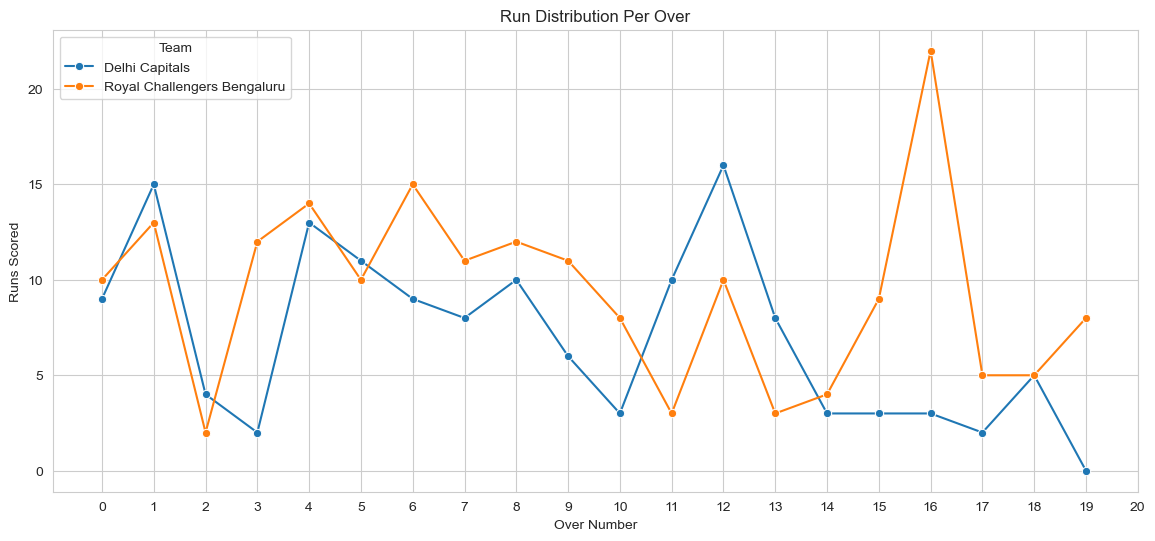

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# data preparation for run distribution per over 
run_distribution = deliveries_df.groupby(['team', 'over']).agg({'runs_total' : 'sum'}).reset_index()

# plotting run distrbution per over  for both teams
plt.figure(figsize=(14,6))
sns.lineplot(data= run_distribution, x='over', y='runs_total', hue='team',marker='o')
plt.title('Run Distribution Per Over')
plt.xlabel('Over Number')
plt.ylabel('Runs Scored')
plt.xticks(range(0, 21)) #over number from 0 to 20
plt.legend(title='Team')
plt.show()

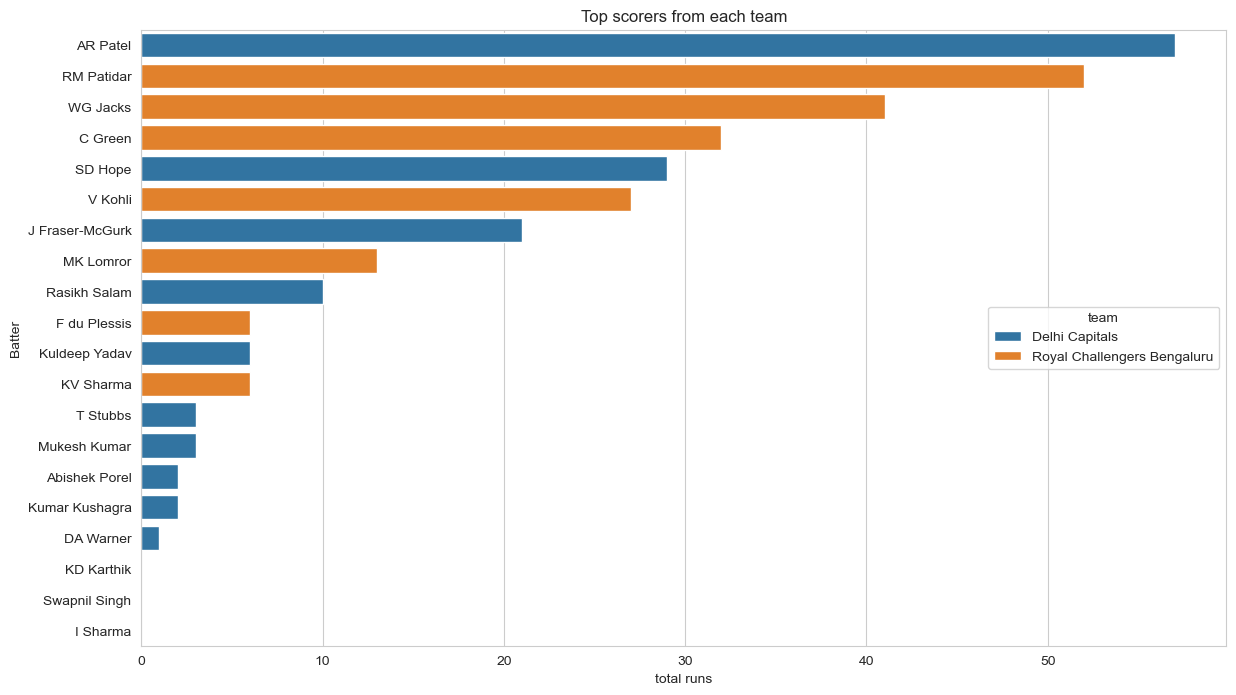

In [3]:
# calculating top scorers for each team
top_scorers = deliveries_df.groupby(['team','batter']).agg({'runs_batter':'sum'}).reset_index().sort_values(by='runs_batter', ascending=False)

plt.figure(figsize=(14,8))
sns.barplot(data=top_scorers, x= 'runs_batter', y= 'batter',hue = 'team', dodge=False)
plt.title('Top scorers from each team')
plt.xlabel('total runs')
plt.ylabel('Batter')
plt.legend(title='team', loc='center right')
plt.show()

bowlers analysis

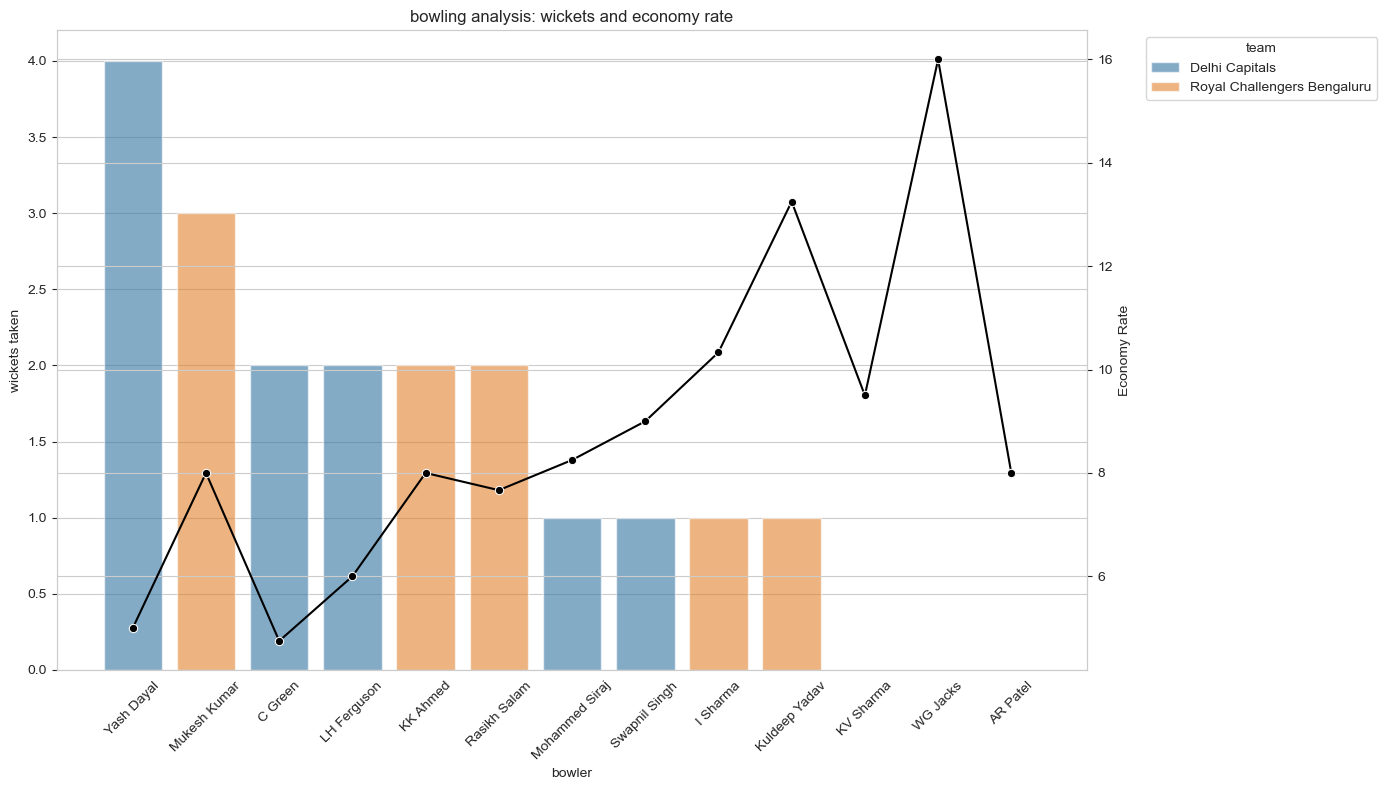

In [4]:
# preparing data for bowling analysis
deliveries_df['wickets_taken'] = deliveries_df['wicket_kind'].notna().astype(int)
bowling_stats = deliveries_df.groupby(['team', 'bowler']).agg({'runs_total': 'sum', 'wickets_taken': 'sum', 'over':'nunique'}).reset_index()

# calculating economy rate (total runs conceded / number of overs bowled)
bowling_stats['economy_rate'] = bowling_stats['runs_total']/ bowling_stats['over']

# sorting the data for bettr visualization 
bowling_stats_sorted = bowling_stats.sort_values(by='wickets_taken',ascending=False)

#prepare the data fram for ploting
bowling_stats_sorted['wicket_taken'] = deliveries_df['wicket_kind'].notna().astype(int)
bowling_stats = deliveries_df.groupby(['team', 'bowler']).agg({'runs_total':'sum','wickets_taken':'sum','over':'nunique'}).reset_index()
bowling_stats['economy_rate']= bowling_stats['runs_total']/bowling_stats['over']
bowling_stats_sorted = bowling_stats.sort_values(by='wickets_taken',ascending=False)

#create the plot
fig, ax1 = plt.subplots(figsize = (14, 8))

#box plot
sns.barplot(data=bowling_stats_sorted,x='bowler',y='wickets_taken',hue= 'team',ax=ax1,alpha=0.6)
ax1.set_ylabel('wickets taken')
ax1.set_xlabel('bowler')
ax1.set_title('bowling analysis: wickets and economy rate')
ax1.legend(title='team', bbox_to_anchor=(1.05, 1),loc ='upper left')

for item in ax1.get_xticklabels():
    item.set_rotation(45)
#line plot for wickets lost 
ax2 = ax1.twinx()
sns.lineplot(data=bowling_stats_sorted, x= 'bowler',y='economy_rate',marker='o',ax=ax2,sort=False, color='black')
ax2.set_ylabel('Economy Rate')

plt.tight_layout()
plt.show()

analyze the type of dismissals apper in the match

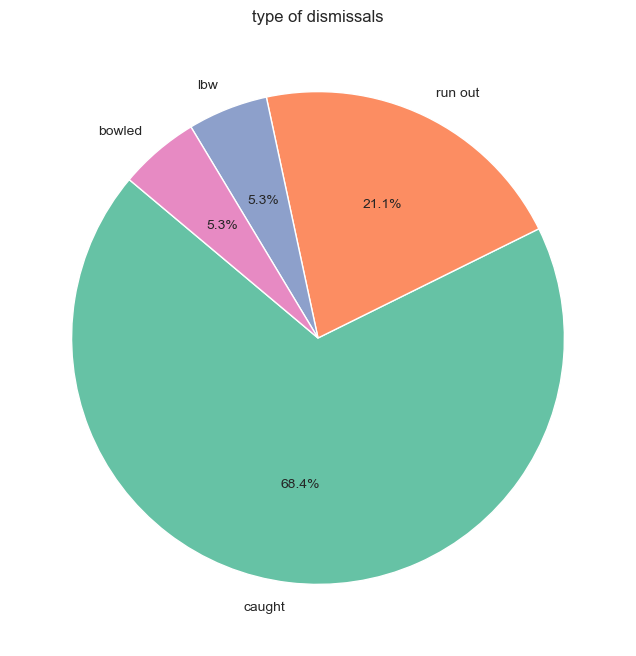

In [5]:
#counting dismissal type 
dismissal_types = deliveries_df['wicket_kind'].dropna().value_counts()

plt.figure(figsize=(8,8))
plt.pie(dismissal_types, labels=dismissal_types.index, autopct='%1.1f%%',startangle=140, colors=sns.color_palette("Set2"))
plt.title('type of dismissals')
plt.show()

partnership analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


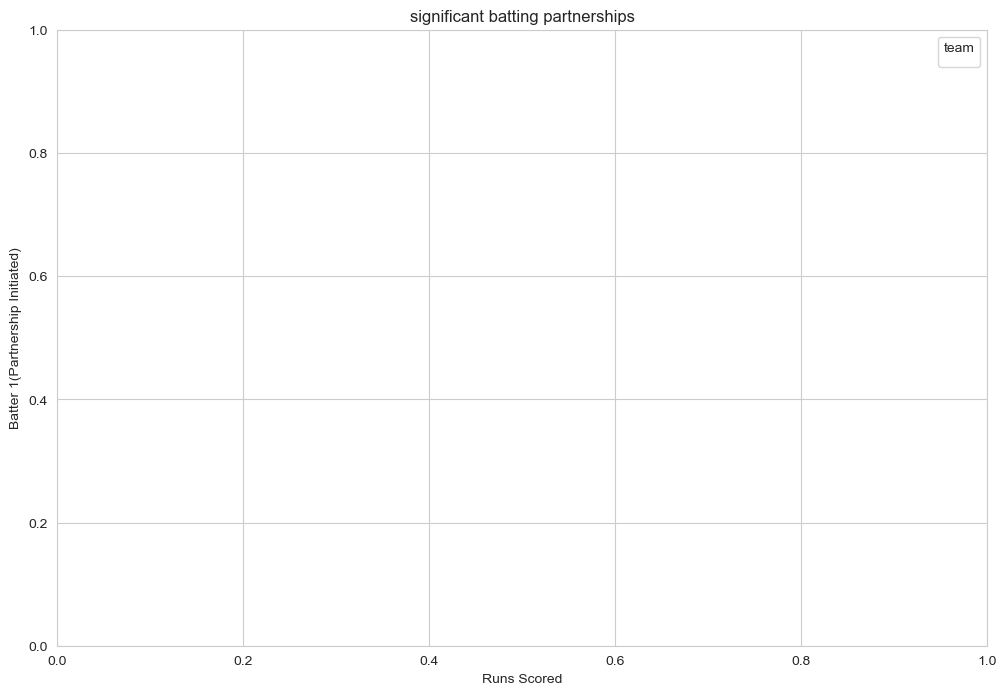

In [6]:
#function to calculate partnerships
def calculate_partnerships(df):
    partnerships = []
    current_partnership = {}
    for i, row in df.iterrows():
        if i  == 0 or (row['batter'] not in current_partnership.values()):
            if current_partnership:
                partnerships.append(current_partnership)
            current_partnership = {
                'team': row['team'],
                'batter1': row['batter'],
                'batter2': row['non_striker'],
                'runs': 0,
                'balls': 0
                }
            current_partnership['runs'] += row['runs_total']
            current_partnership['balls'] += 1
            if 'player_out' in row and pd.notna(row['player_out']):
                if row['player_out'] == current_partnership['batter1'] or row['player_out'] == current_partnership['batter2']:
                    partnerships.append(current_partnership)
                    current_partnership = {}
        
        if current_partnership:
             partnerships.append(current_partnership)
        return partnerships

partnerships_data = calculate_partnerships(deliveries_df)
partnerships_df = pd.DataFrame(partnerships_data)

significant_partnerships = partnerships_df[partnerships_df['runs'] >20]

significant_partnerships = significant_partnerships.sort_values(by='runs', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=significant_partnerships, x='runs', y='batter1', hue='team', dodge=False)
plt.title('significant batting partnerships')
plt.xlabel('Runs Scored')
plt.ylabel('Batter 1(Partnership Initiated)')
plt.legend(title = 'team' )
plt.show()

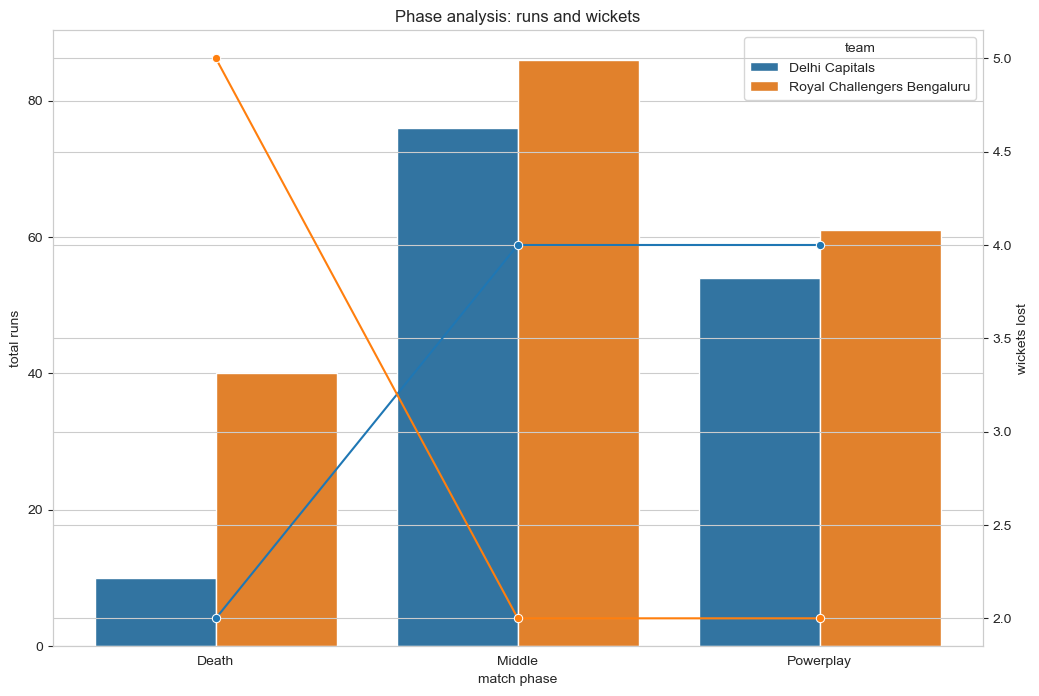

In [7]:
# function to classify
def classify_phase(over):
    if over < 6:
        return 'Powerplay'
    elif over < 16: 
            return 'Middle'
    else:
      return 'Death'


deliveries_df['phase'] = deliveries_df['over'].apply(classify_phase)

phase_analysis = deliveries_df.groupby(['team', 'phase']).agg({'runs_total': 'sum','wickets_taken':'sum', 'over':'count'}).rename(columns={'over':'balls'}).reset_index()

phase_analysis['run_rate'] = (phase_analysis['runs_total']/ phase_analysis['balls']) * 6

fig, ax1 = plt.subplots(figsize=(12,8))

sns.barplot(data=phase_analysis, x='phase', y='runs_total',hue='team', ax=ax1)
ax1.set_title('Phase analysis: runs and wickets')
ax1.set_ylabel('total runs')
ax1.set_xlabel('match phase')

ax2 = ax1.twinx()
sns.lineplot(data=phase_analysis, x='phase',y='wickets_taken', hue='team',marker='o', ax=ax2,legend=False)
ax2.set_ylabel('wickets lost')

plt.show()

calculating strike rate of batters

In [8]:
batter_stats = deliveries_df.groupby('batter').agg({'runs_batter': 'sum','over':'count'}).rename(columns={'over':'balls_faced'}).reset_index()

batter_stats['strike_rate'] = (batter_stats['runs_batter']/batter_stats['balls_faced'])*100

batter_stats_sorted = batter_stats.sort_values(by='strike_rate',ascending=False)

batter_stats_sorted.head(10)

,batter,runs_batter,balls_faced,strike_rate
6,J Fraser-McGurk,21,8,262.500000
18,V Kohli,27,14,192.857143
13,RM Patidar,52,34,152.941176
8,KV Sharma,6,4,150.000000
0,AR Patel,57,40,142.500000
19,WG Jacks,41,30,136.666667
2,C Green,32,24,133.333333
11,MK Lomror,13,10,130.000000
15,SD Hope,29,24,120.833333
4,F du Plessis,6,7,85.714286


top performance

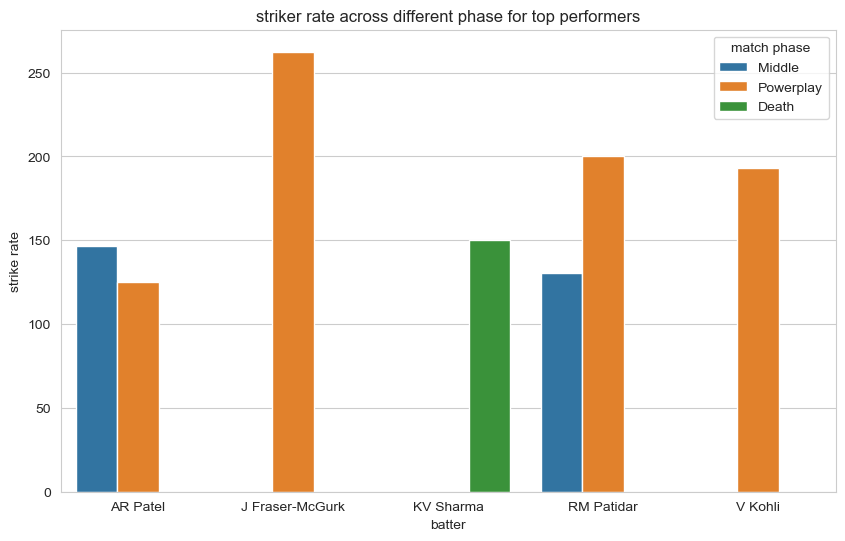

In [9]:
batter_phase_stats = deliveries_df.groupby(['batter', 'phase']).agg({'runs_batter': 'sum','over':'count'}).rename(columns={'over':'balls_faced'}).reset_index()

batter_phase_stats['strike_rate'] = (batter_phase_stats['runs_batter']/batter_phase_stats['balls_faced'])*100

top_performers = batter_stats_sorted.head(5)['batter']
batter_phase_stats_top = batter_phase_stats[batter_phase_stats['batter'].isin(top_performers)]

plt.figure(figsize=(10,6))
sns.barplot(data= batter_phase_stats_top, x='batter', y= 'strike_rate', hue='phase')
plt.title('striker rate across different phase for top performers')
plt.xlabel('batter')
plt.ylabel('strike rate')
plt.legend(title='match phase')
plt.show()

identifing turning point of matchs

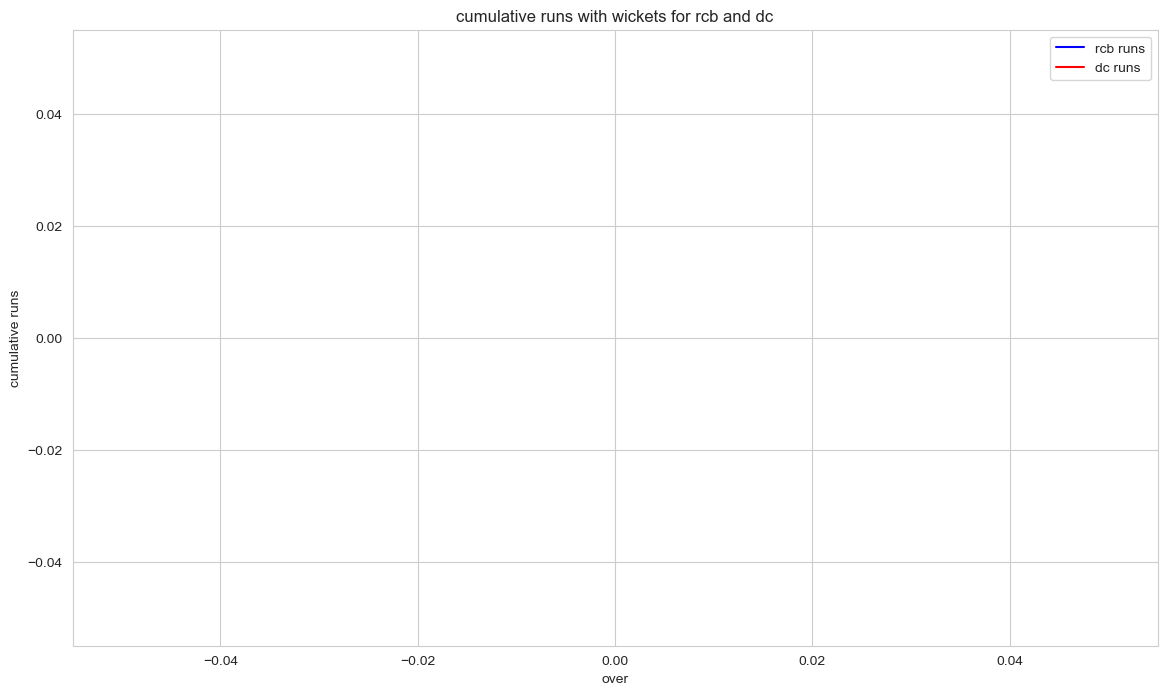

In [10]:
deliveries_df['cumulative_runs'] = deliveries_df.groupby('team')['runs_total'].cumsum()
deliveries_df['cumulative_wickets'] = deliveries_df.groupby('team')['wickets_taken'].cumsum()


rcb_deliveries = deliveries_df[deliveries_df['team'] == 'royal challengers bengaluru']
dc_deliveries = deliveries_df[deliveries_df['team'] == 'delhi capitals']

rcb_deliveries['over_ball'] = rcb_deliveries['over'] + (rcb_deliveries.groupby('over').cumcount() + 1)/6
dc_deliveries['over_ball'] = dc_deliveries['over'] + (dc_deliveries.groupby('over').cumcount() + 1)/6

fig, ax = plt.subplots(figsize=(14,8))


ax.plot(rcb_deliveries['over_ball'], rcb_deliveries['cumulative_runs'], color = 'blue', label = 'rcb runs')
ax.scatter(rcb_deliveries[rcb_deliveries['wickets_taken'] == 1]['over_ball'], rcb_deliveries[rcb_deliveries['wickets_taken'] == 1]['cumulative_runs'], color='blue', marker='X',s=100)

ax.plot(dc_deliveries['over_ball'],dc_deliveries['cumulative_runs'], color= 'red',label='dc runs')
ax.scatter(dc_deliveries[dc_deliveries['wickets_taken'] == 1]['over_ball'], dc_deliveries[dc_deliveries['wickets_taken'] ==1]['cumulative_runs'],color='red',marker='X',s=100)


ax.set_title('cumulative runs with wickets for rcb and dc')
ax.set_xlabel('over')
ax.set_ylabel('cumulative runs')
ax.legend()
plt.show()

calculate the run rate for each teams

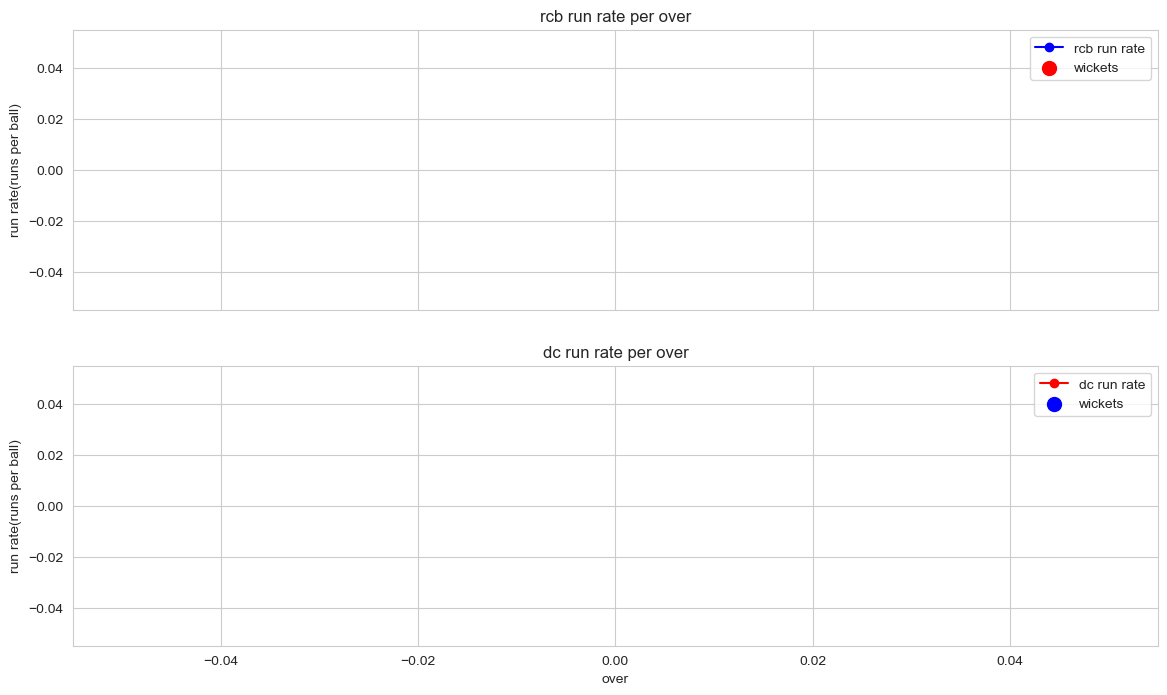

In [11]:
per_over_stats = deliveries_df.groupby(['team', 'over']).agg({'runs_total':  'sum' ,'wickets_taken': 'sum'}).reset_index()

per_over_stats ['run_rate'] = (per_over_stats['runs_total']/6)

rcb_per_over_stats = per_over_stats[per_over_stats['team'] =='royal challenger bengaluru']
dc_per_over_stats = per_over_stats[per_over_stats['team'] =='delhi capitals']

fig,(ax1, ax2) = plt.subplots(2,1, figsize=(14,8),sharex=True)

ax1.plot(rcb_per_over_stats['over'], rcb_per_over_stats['run_rate'], marker='o', color='blue', label='rcb run rate')
ax1.scatter(rcb_per_over_stats[rcb_per_over_stats['wickets_taken'] > 0]['over'], rcb_per_over_stats[rcb_per_over_stats['wickets_taken'] > 0]['run_rate'],color='red', s=100, label='wickets')
ax1.set_title('rcb run rate per over')
ax1.set_ylabel('run rate(runs per ball)')
ax1.legend()

ax2.plot(dc_per_over_stats['over'], dc_per_over_stats['run_rate'], marker='o', color='red', label='dc run rate')
ax2.scatter(dc_per_over_stats[dc_per_over_stats['wickets_taken'] > 0]['over'], dc_per_over_stats[dc_per_over_stats['wickets_taken'] > 0]['run_rate'],color='blue', s=100, label='wickets')
ax2.set_title('dc run rate per over')
ax2.set_xlabel('over')
ax2.set_ylabel('run rate(runs per ball)')
ax2.legend()

plt.show()